# TP : Sentiment analysis on IMDB movie reviews

## Rémi JAYLET et Hugues René-Bazin

## Objectives

1. Implement a simple way to represent text data - Bag of words
2. Implement a basic statistical learning model - Bayesian Naive
3. Use these representations and this model for a sentiment analysis task.
4. Implement different ways of obtaining dense representations of the same data
5. Use a logistic regression model to train a classifier on these new representations.

## Necessary dependancies

We will need the following packages:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html

Both are available with Anaconda: https://anaconda.org/anaconda/nltk and https://anaconda.org/anaconda/scikit-learn

In [81]:
import os.path as op
import re 
import numpy as np
import matplotlib.pyplot as plt
import operator

## Loading data

We retrieve the textual data in the variable *texts*.

The labels are retrieved in the variable $y$ - it contains *len(texts)* of them: $0$ indicates that the corresponding review is negative while $1$ indicates that it is positive.

In [3]:
from glob import glob
# We get the files from the path: ./data/imdb1/neg for negative reviews, and ./data/imdb1/pos for positive reviews
filenames_neg = sorted(glob(op.join('.', 'data/data', 'imdb1', 'neg', '*.txt')))
filenames_pos = sorted(glob(op.join('.', 'data/data', 'imdb1', 'pos', '*.txt')))

# Each files contains a review that consists in one line of text: we put this string in two lists, that we concatenate
texts_neg = [open(f, encoding="utf8").read() for f in filenames_neg]
texts_pos = [open(f, encoding="utf8").read() for f in filenames_pos]
texts = texts_neg + texts_pos

# The first half of the elements of the list are string of negative reviews, and the second half positive ones
# We create the labels, as an array of [1,len(texts)], filled with 1, and change the first half to 0
y = np.ones(len(texts), dtype=np.int)
y[:len(texts_neg)] = 0.

print("%d documents" % len(texts))

25000 documents


In [34]:
# This number of documents may be high for most computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k = 10
texts_reduced = texts[0::k]
y_reduced = y [0::k]

print('Number of documents:', len(texts_reduced))

Number of documents: 2500


# Naive Bayesian 

## Main idea

A movie review is in fact a list of words $s = (w_1, ..., w_N)$, and we try to find the associated class $c$ - which in our case may be $c = 0$ or $c = 1$. The objective is thus to find for each review $s$ the class $\hat{c}$ maximizing the conditional probability **$P(c|s)$** : 

$$\hat{c} = \underset{c}{\mathrm{argmax}}\, P(c|s) = \underset{c}{\mathrm{argmax}}\,\frac{P(s|c)P(c)}{P(s)}$$

**Hypothesis : P(s) is constant for each class** :

$$\hat{c} = \underset{c}{\mathrm{argmax}}\,\frac{P(s|c)P(c)}{P(s)} = \underset{c}{\mathrm{argmax}}\,P(s|c)P(c)$$

**Naive hypothesis : the variables (words) of a review are independant between themselves** : 

$$P(s|c) = P(w_1, ..., w_N|c)=\Pi_{i=1..N}P(w_i|c)$$

We will therefore be able to use the reviews at our disposal to **estimate the probabilities $P(w|c)$ for each word $w$ given the two classes $c$**. These reviews will allow us to learn how to evaluate the "compatibility" between words and classes.

## General view

### Training: Estimating the probabilities

For each word $w$ in the vocabulary $V$, $P(w|c)$ is the number of occurrences of $w$ in all reviews of class $c$, divided by the total number of occurrences in $c$. If we note $T(w,c)$ this number of occurrences, we get:

$$P(w|c) = \text{Frequency of }w\text{ in }c = \frac{T(w,c)}{\sum_{w' \in V} T(w',c)}$$

### Test: Calculating scores

To facilitate the calculations and to avoid *underflow* and approximation errors, we use the log-sum trick, and we pass the equation into log-probabilities : 

$$ \hat{c} = \underset{c}{\mathrm{argmax}} P(c|s) = \underset{c}{\mathrm{argmax}} \left[ \mathrm{log}(P(c)) + \sum_{i=1..N}log(P(w_i|c)) \right] $$

### Laplace smoothing

A word that does not appear in a document has a probability of zero: this will cause issues with the logarithm. So we keep a very small part of the probability mass that we redistribute with the *Laplace smoothing*: 

$$P(w|c) = \frac{T(w,c) + 1}{\sum_{w' \in V} (T(w',c) + 1)}$$

There are other smoothing methods, generally suitable for other, more complex applications. 

## Adapted representation of documents

Our statistical model, like most models applied to textual data, uses counts of word occurrences in a document. Thus, a very convenient way to represent a document is to use a Bag-of-Words (BoW) vector, containing the counts of each word (regardless of their order of occurrence) in the document. 

If we consider the set of all the words appearing in our $T$ training documents, which we note $V$ (Vocabulary), we can create **an index**, which is a bijection associating to each $w$ word an integer, which will be its position in $V$. 

Thus, for a document extracted from a set of documents containing $|V|$ different words, a BoW representation will be a vector of size $|V|$, whose value at the index of a word $w$ will be its number of occurrences in the document. 

We can use the **CountVectorizer** class from scikit-learn to better understand:

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin

In [36]:
corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']
vectorizer = CountVectorizer()

Bow = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names())
Bow.toarray()

['avenue', 'boulevard', 'city', 'down', 'ran', 'the', 'walk', 'walked']


array([[0, 1, 0, 2, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 2, 1, 0]], dtype=int64)

We display the list containing the words ordered according to their index (Note that words of 2 characters or less are not counted).

## Detail: training

The idea is to extract the number of occurrences $T(w,c)$ for each word $w$ and each class $c$, which will make it possible to calculate the matrix of conditional probabilities $\pmb{P}$ such that: $$\pmb{P}_{w,c} = P(w|c)$$

Note that the number of occurrences $T(w,c)$ can be easily obtained from the BoW representations of all documents !

### Procedure:

- Extract the vocabulary $V$ and counts $T(w,c)$ for each of the words $w$ and classes $c$, from a set of documents.
- Calculate the a priori probabilities of the classes $P(c) = \frac{\sum_{w \in V} T(w,c)}{\sum_{c \in C} \sum_{w \in V} T(w,c)}$
- Calculate the conditional **smoothed** probabilities $P(w|c) = \frac{T(w,c) + 1}{\sum_{w' \in V} T(w',c) + 1}$.

## Detail: test

We now know the conditional probabilities given by the $\pmb{P}$ matrix. 
Now we must obtain $P(s|c)$ for the current document. This quantity is obtained using a simple calculation involving the BoW representation of the document and $\pmb{P}$.

### Procedure:

- For each of the classes $c$,
    - $Score(c) = \log P(c)$
    - For each word $w$ in the document to be tested:
        - $Score(c) += \log P(w|c)$
- Return $argmax_{c \in C} Score(c)$ 

## Preprocessing the text: get the BoW representations ##

The first thing to do is to turn the review from a string into a list of words. The simplest method is to divide the string according to spaces with the command:
``text.split()``

But we must also be careful to remove special characters that may not have been cleaned up (such as HTML tags if the data was obtained from web pages). Since we're going to count words, we'll have to build a list of tokens appearing in our data. In our case, we'd like to reduce this list and make it uniform (ignore capitalization, punctuation, and the shortest words). 
We will therefore use a function adapted to our needs - but this is a job that we generally don't need to do ourselves, since there are many tools already adapted to most situations. 
For text cleansing, there are many scripts, based on different tools (regular expressions, for example) that allow you to prepare data. The division of the text into words and the management of punctuation is handled in a step called *tokenization*; if needed, a python package like NLTK contains many different *tokenizers*.

In [37]:
import nltk
nltk.download('punkt')

# We might want to clean the file with various strategies:
def clean_and_tokenize(text):
    """
    Cleaning a document with:
        - Lowercase        
        - Removing numbers with regular expressions
        - Removing punctuation with regular expressions
        - Removing other artifacts
    And separate the document into words by simply splitting at spaces
    Params:
        text (string): a sentence or a document
    Returns:
        tokens (list of strings): the list of tokens (word units) forming the document
    """        
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r"[0-9]+", "", text)
    # Remove punctuation
    REMOVE_PUNCT = re.compile("[.;:!\'?,\"()\[\]]")
    text = REMOVE_PUNCT.sub("", text)
    # Remove small words (1 and statistique2 characters)
    text = re.sub(r"\b\w{1,2}\b", "", text)
    # Remove HTML artifacts specific to the corpus we're going to work with
    REPLACE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    text = REPLACE_HTML.sub(" ", text)
    
    tokens = text.split()        
    return tokens

# Or we might want to use an already-implemented tool. The NLTK package has a lot of very useful text processing tools, among them various tokenizers
# Careful, NLTK was the first well-documented NLP package, but it might be outdated for some uses. Check the documentation !
from nltk.tokenize import word_tokenize

corpus_raw = "I walked down down the boulevard. I walked down the avenue. I ran down the boulevard. I walk down the city. I walk down the the avenue."
print(clean_and_tokenize(corpus_raw))
print(word_tokenize(corpus_raw))

['walked', 'down', 'down', 'the', 'boulevard', 'walked', 'down', 'the', 'avenue', 'ran', 'down', 'the', 'boulevard', 'walk', 'down', 'the', 'city', 'walk', 'down', 'the', 'the', 'avenue']
['I', 'walked', 'down', 'down', 'the', 'boulevard', '.', 'I', 'walked', 'down', 'the', 'avenue', '.', 'I', 'ran', 'down', 'the', 'boulevard', '.', 'I', 'walk', 'down', 'the', 'city', '.', 'I', 'walk', 'down', 'the', 'the', 'avenue', '.']


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\remij\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Function **to be completed**. It takes as input a list of documents (each in the form of a string) and returns, as in the example using ``CountVectorizer``:
- A vocabulary that associates, to each word encountered, an index
- A matrix, with rows representing documents and columns representing words indexed by the vocabulary. In position $(i,j)$, one should have the number of occurrences of the word $j$ in the document $i$.

The vocabulary, which was in the form of a *list* in the previous example, can be returned in the form of a *dictionary* whose keys are the words and values are the indices. Since the vocabulary lists the words in the corpus without worrying about their number of occurrences, it can be built up using a set (in python). 
Of course, we can use the function ``clean_and_tokenize'' to transform the strings into a list of words. 

##### Some pointers for beginners in Python :

- ```my_list.append(value)``` : put the variable ```value``` at the end of the list ```my_list```

-  ```words = set()``` : create a set, which is a list of unique values 

- ```words.union(my_list)``` : extend the set ```words```

- ```dict(zip(keys, values)))``` : create a dictionnary

- ```for k, text in enumerate(texts)``` : syntax for a loop with the index, ```texts``` begin a list (of texts !)

- ```len(my_list)``` : length of the list ```my_list```


In [38]:
def count_words(texts):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    vocabulary = {}
    index = 0
    for text in texts: 
        
        word_list = clean_and_tokenize(text)
        
        for word in word_list:
            if word not in vocabulary.keys():
                vocabulary[word]= index  # add word if he is not in list
                index+=1
   
    shape = (len(texts), len(vocabulary.keys()))
    counts = np.zeros(shape) 
    
    k = 0
    for text in texts: 
        
        word_list = clean_and_tokenize(text)
        
        for word in word_list:
            idx = vocabulary[word]
            counts[k][idx] +=1  # increment counts at the corresponding location 
        k+=1 
            
        
    return vocabulary, counts

In [9]:
Voc, X = count_words(corpus)
print(Voc)
print(X)

{'walked': 0, 'down': 1, 'the': 2, 'boulevard': 3, 'avenue': 4, 'ran': 5, 'walk': 6, 'city': 7}
[[1. 2. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 1. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 0.]
 [0. 1. 1. 0. 0. 0. 1. 1.]
 [0. 1. 2. 0. 1. 0. 1. 0.]]


For X : 1 column = 1 word, 1 line = 1 text

The function works for the corpus ('I' is not counted as it is a word with less than 2 caracters)

## Naive Bayesian 

Empty class: functions **to be completed** : 

```python
def fit(self, X, y)
``` 
**Training**: will learn a statistical model based on the representations $X$ corresponding to the labels $y$.
Here, $X$ contains representations obtained as the output of ```count_words```. You can complete the function using the procedure detailed above. 

Note: the smoothing is not necessarily done with a $1$ - it can be done with a positive value $\alpha$, which we can implement as an argument of the class "NB".

```python
def predict(self, X)
```
**Testing**: will return the labels predicted by the model for other representations $X$.



To facilitate the procedure, we will take half of the $X$ matrix obtained above to train the model, and the other half to evaluate it. **Important**: this is not realistic - usually only the training data is available when creating the vocabulary and training the model. Thus, it is possible that the evaluation data may contain *unknown* words. This is something that can easily be dealt with by dedicating a clue to all the words encountered that are not contained in the vocabulary - but there are many more complex methods for successfully using those words that the model did not encounter in training. 

##### Some pointers for beginners in Python :

Use the Numpy API to work with arrays:


- ```X.shape``` : for a ```numpy.array```, return the dimension of the tensor

- ```np.zeros((dim_1, dim_2,...))``` : create a tensor filled with zeros

- ```np.sum(X, axis = n)``` : sum the tensor over the axis n

- ```np.mean(X, axis = n)```

- ```np.argmax(X, axis = n)```

- ```np.log(X)```

- ```np.dot(X_1, X_1)``` : Matrix multiplication

In [179]:
class NB(BaseEstimator, ClassifierMixin):
    
    def __init__(self):
        self.Pwc = dict()
        self.p_c = np.zeros(2)
        
    def fit(self, X, y):
        
        T = dict()
        
        # split X matrix in pos and neg
        T[0] = np.sum(X[y==0, :], axis=0)
        T[1] = np.sum(X[y==1, :], axis=0)
        
        N = X.shape[0]
        val, counter = np.unique(y, return_counts=True)
        self.class_counter = dict(zip(val, counter))
        
        for c, num_c in self.class_counter.items():
            self.p_c[c] = num_c/N
            self.Pwc[c] = (T[c] +1) / ( np.sum(T[c] + 1))
        return self

    
    def predict(self, X):
        X = np.array(X)
        y = []
        
        for x in X:
            x = np.array(x)
            score = dict()
            for c in self.class_counter:
                score[c] = np.log(self.p_c[c])
                score[c] += np.log(self.Pwc[c][x >0.0]).sum()
            res =  max(score.items(), key=operator.itemgetter(1))[0]  # take max of the 2 lines
            y.append(res)

        return np.array(y)
    
    def score(self, X, y):
        return np.mean(self.predict(X) == y)

## Experimentation

We use half the data for training, and the other half for evaluation.

In [180]:
voc, X = count_words(texts_reduced)

In [181]:
nb = NB()
nb.fit(X[::2], y_reduced[::2])

NB()

In [182]:
print(nb.predict((X[1::2])))

[0 0 0 ... 0 1 1]


In [183]:
s = nb.score(X[1::2], y_reduced[1::2])
print("Score of train :", round(s,3))

Score of train : 0.798


## Cross-validation 

With the function *cross_val_score* from scikit-learn

In [184]:
scores = cross_val_score(nb, X, y_reduced, cv=5)
print('Classification score: %s (std %s)' % (np.mean(scores), np.std(scores)))

Classification score: 0.7932 (std 0.02714700720153142)


## Evaluating performances: 

**What are the strengths and weaknesses of this system? How can they be remedied?**

The strenghs of this system is that it is not very complex but efficient. But the weaknesses are that we can find much more efficient algorithms that are faster.

## To go further: 

In [185]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

## Scikit-learn

### Improving representations

We use the function 
```python
CountVectorizer
``` 
of scikit-learn. It will allow us to easily improve our BoW representations.

#### Tf-idf:

This is the product of the frequency of the term (TF) and its inverse frequency in documents (IDF).
This method is usually used to measure the importance of a term $i$ in a document $j$ relative to the rest of the corpus, from a matrix of occurrences $ words \times documents$. Thus, for a matrix $\mathbf{T}$ of $|V|$ terms and $D$ documents:
$$\text{TF}(T, w, d) = \frac{T_{w,d}}{\sum_{w'=1}^{|V|} T_{w',d}} $$

$$\text{IDF}(T,w) = \log\left(\frac{D}{|\{T_{w,d} > 0\}|}\right)$$

$$\text{TF-IDF}(T, w, d) = \text{TF}(T, w, d) \cdot \text{IDF}(T, w)$$

It can be adapted to our case by considering that the context of the second word is the document. However, TF-IDF is generally better suited to low-density matrices, since it will penalize terms that appear in a large part of the documents. 
    
#### Do not take into account words that are too frequent:

You can use the argument
```python
max_df=1.0
```
to change the amount of words taken into account. 

#### Try different granularities:

Rather than just counting words, we can count sequences of words - limited in size, of course. 
We call a sequence of $n$ words a $n$-gram: let's try using 2 and 3-grams (bi- and trigrams).
We can also try to use character sequences instead of word sequences.

We will be interested in the options 
```python
analyze='word'
```
and 
```python
ngram_range=(1, 2)
```
which we'll change to alter the granularity. 

In [186]:
## We can define a pipeline, with which we can experiment.

pipeline_base = Pipeline([
    ('vect', CountVectorizer(analyzer='word', stop_words=None)),
    ('clf', MultinomialNB()),
])
scores = cross_val_score(pipeline_base, texts_reduced, y_reduced, cv=5)
print("Classification score: %s (std %s)"%(round(np.mean(scores),3), round(np.std(scores),3)))

# TfidfTransformer 

pipeline_tf_idf = Pipeline([
    ('vect', CountVectorizer(analyzer='word',ngram_range=(1,3) , stop_words=None)),
    ('vect_tfidf', TfidfTransformer()), 
    ('clf', MultinomialNB()),
])
scores = cross_val_score(pipeline_tf_idf, texts_reduced, y_reduced, cv=5)
print("Classification score tf-idf: %s (std %s)"%(round(np.mean(scores),3), round(np.std(scores),3)))

#  max_df parameter 

pipeline_maxdf = Pipeline([
    ('vect', CountVectorizer(analyzer = 'word', stop_words=None, max_df=1.0)),
    ('clf', MultinomialNB()),
])
scores = cross_val_score(pipeline_maxdf, texts_reduced, y_reduced, cv=5)
print("Classification score sans mots fréquents: %s (std %s)"%(round(np.mean(scores),3), round(np.std(scores),3)))

# bigram 
pipeline_bigram = Pipeline([
    ('vect', CountVectorizer(analyzer = 'word', stop_words = None,ngram_range=(1, 2))),
    ('clf', MultinomialNB()),
])
scores = cross_val_score(pipeline_bigram, texts_reduced, y_reduced, cv=5)
print("Classification score bigram: %s (std %s)"%(round(np.mean(scores),3), round(np.std(scores),3)))


#trigram 
pipeline_trigram = Pipeline([
    ('vect', CountVectorizer(analyzer = 'word', stop_words = None,ngram_range=(1, 3))),
    ('clf', MultinomialNB()),
])
scores = cross_val_score(pipeline_trigram, texts_reduced, y_reduced, cv=5)
print("Classification score trigram: %s (std %s)"%(round(np.mean(scores),3), round(np.std(scores),3)))

pipeline_char = Pipeline([
    ('vect', CountVectorizer(analyzer='char', stop_words=None)),
    ('clf', MultinomialNB()),
])
scores = cross_val_score(pipeline_char, texts_reduced, y_reduced, cv=5)
print("Classification score char: %s (std %s)"%(round(np.mean(scores),3), round(np.std(scores),3)))

Classification score: 0.781 (std 0.021)
Classification score tf-idf: 0.812 (std 0.022)
Classification score sans mots fréquents: 0.781 (std 0.021)
Classification score bigram: 0.805 (std 0.017)
Classification score trigram: 0.816 (std 0.016)
Classification score char: 0.611 (std 0.027)


The implementation through sklearn gives approximatly the same results but the computation is faster.

The results show that performance is good for any given implementation however bigram/trigram are work more efficiently. Furthermore, removing the stop_words can not always improve the performances.  

The best score is obtained with trigram (i.e. ngram_range=(1,3)).

### Natural Language Toolkit (NLTK)

### Stemming 

Allows to go back to the root of a word: you can group different words around the same root, which facilitates generalization. Use:
```python
from nltk import SnowballStemmer
```

In [187]:
from nltk import SnowballStemmer
stemmer = SnowballStemmer("english")

#### Example:

In [188]:
words = ['singers', 'cat', 'generalization', 'philosophy', 'psychology', 'philosopher']
for word in words:
    print('word : %s ; stemmed : %s' %(word, stemmer.stem(word)))#.decode('utf-8'))))

word : singers ; stemmed : singer
word : cat ; stemmed : cat
word : generalization ; stemmed : general
word : philosophy ; stemmed : philosophi
word : psychology ; stemmed : psycholog
word : philosopher ; stemmed : philosoph


#### Application:

Empty class : function **to complete** 
```python
def stem(X)
``` 

In [189]:
def stem(X): 
    X_stem = []
    
    for texts in X:
        List = clean_and_tokenize(texts)
        L =[]
        for w in List:
            L.append(stemmer.stem(w))
        X_stem.append(" ".join(L))  # add words of list to concatenate text 
           
    return X_stem

In [190]:
texts_stemmed = stem(texts_reduced)
voc, X = count_words(texts_stemmed)
nb = NB()

scores = cross_val_score(nb, X, y_reduced, cv=5)
print('Classification score: %s (std %s)' % (np.mean(scores), np.std(scores)))


Classification score: 0.7856 (std 0.02350829640786416)


We can see that Stem does not have a significant influence on the classification.

### Part of speech tags

To generalize, we can also use the Part of Speech (POS) of the words, which will allow us to filter out information that is potentially not useful to the model. We will retrieve the POS of the words using the functions:
```python
from nltk import pos_tag, word_tokenize
```

In [191]:
import nltk
from nltk import pos_tag, word_tokenize

#### Example:

In [192]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

pos_tag(word_tokenize(('I am Sam')))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\remij\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\remij\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('I', 'PRP'), ('am', 'VBP'), ('Sam', 'NNP')]

Details of POS tags meanings: https://stackoverflow.com/questions/15388831/what-are-all-possible-pos-tags-of-nltk

#### Application:

Empty class : function **to complete** 
```python
def pos_tag_filter(X, good_tags=['NN', 'VB', 'ADJ', 'RB'])
``` 

Only keeps nouns, adverbs, verbs and adjectives for our model. 

In [193]:
import re

bool(re.search('NN',('I', 'NN')[1]))

True

In [194]:
import re

def pos_tag_filter(X, good_tags=['NN', 'VB', 'ADJ', 'RB']):
    X_pos = []
    
    for text in X:
        # should we use clean_and_tokenize ? 
        PT = pos_tag(word_tokenize(text))
        good_PT = []
        for word in PT:
            for tag in good_tags:
                if bool(re.search(tag,word[1])):
                    good_PT.append(word[0])  # keep only good tags
                    
        X_pos.append(" ".join(good_PT))
                 
    return X_pos

In [195]:
texts_POS = pos_tag_filter(texts_reduced)
voc, X = count_words(texts_POS)
nb = NB()

scores = cross_val_score(nb, X, y_reduced, cv=5)
print('Classification score: %s (std %s)' % (np.mean(scores), np.std(scores)))

Classification score: 0.7544000000000001 (std 0.018304097901836097)


The score is lower because certain types of words are not taken into account.

## Using a more complex classifier?

We can use scikit-learn implementations of less naive classifiers, such as logistic regression or SVM. What is the main disadvantage of this (let's imagine that, rather than a linear model, we choose to use a neural network with several hidden layers)?

> The first problem that can occur is that this can increase the computation time and lead to overfitting.

In [196]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [197]:
pipeline_logistic = Pipeline([
    ('vect', CountVectorizer(analyzer='word', stop_words=None)),
    ('LinearSVC', LinearSVC()),
])
scores = cross_val_score(pipeline_logistic, texts_reduced, y_reduced, cv=5)
print("Classification score: %s (std %s)" % (round(np.mean(scores),3), round(np.std(scores),3)))

pipeline_svm = Pipeline([
    ('vect', CountVectorizer(analyzer='word', stop_words=None)),
    ('SVM', LogisticRegression(max_iter=1000))
])
scores = cross_val_score(pipeline_svm, texts_reduced, y_reduced, cv=5)
print("Classification score: %s (std %s)" % (round(np.mean(scores),3), round(np.std(scores),3)))

C:\Users\remij\Miniconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\remij\Miniconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Classification score: 0.799 (std 0.008)
Classification score: 0.808 (std 0.007)


The score is slightly better but there is no significant improvement

# Dense Representations 

##  Word Embeddings : Distributed representations via the distributional hypothesis 

**Goal**: We will try to obtain dense representations (as vectors of real numbers) of words (and possibly sentences). These representations are intended to be distributed: they are non-local representations. We represent an object as a combination of *features*, as opposed to the attribution of a dedicated symbol: see the founding work of Geoffrey Hinton, among others, on the subject: [Distributed Representations](https://web.stanford.edu/~jlmcc/papers/PDP/Chapter3.pdf).

The term *distributed* representations is very general, but is what we are looking for. The challenge is therefore to be able to build, automatically, such representations.

**Underlying idea**: It is based on the distributional hypothesis: contextual information is sufficient to obtain a viable representation of linguistic objects.
 - For a large class of cases [...] the meaning of a word is its use in the language." Wittgenstein (Philosophical Investigations, 43 - 1953)
 - You shall know a word by the company it keeps, Firth.

Thus, a word can be characterized by the words that accompany it, via co-occurrence counts. Two words with a similar meaning will have a similar contextual distribution and are therefore more likely to appear in similar contexts. This hypothesis can be used as a justification for the application of statistics to semantics (information extraction, semantic analysis). It also allows some form of generalization: we can assume that the information we have about a word will be generalized to words with a similar distribution. 

**Motivation**: The goal is to obtain distributed representations in order to be able to effectively**:
- Directly perform a semantic surface analysis.
- Use it as a source of information for other language-related models and applications, especially for sentiment analysis. 


**Terminology**: Be careful not to confuse the idea of *distributed* and *distributional* representation. The latter generally indicates (for words) that the representation has been obtained strictly from co-occurrence counts, whereas additional information (document labels, part of speech tags, ...) can be used to build distributed representations. 
The models that allow to build these dense representations, in the form of vectors, are often called *vector spaces models*. These representations are also regularly called *word embeddings*, because the words are embedded in a vector space. In French, we often find the term *word embedding* or *lexical embedding*.

## Getting representations: counts of occurrences and co-occurrences

Depending on the type of corpus available, different types of distributional information can be obtained. If we have access to a collection of documents, we can thus choose to count the number of occurrences of each word in each document, to obtain a $words \times documents$ matrix: it is on this principle that **Tf-Idf** is built. We will now look at a more general case: we have a large amount of data in text form, and we want to obtain representations of words in the form of vectors of reduced size, without the need to divide them into documents or categories. 

Suppose we have a corpus containing $T$ different words. We will construct a $\mathbf{M}$ matrix of size $T \times T$ which will contain the number of co-occurrences between words. There will be different factors to consider when constructing this matrix: 

- How do you define the 'context' of a word - context which will tell you what terms co-occur with that word?

We can choose to use different scales: the document, the sentence, the nominal group, or simply a window of $k$ words, depending on the information we want to capture.


- How do we quantify the importance of the counts? 

$\rightarrow$ For example, we can give a decreasing weight to a co-occurrence according to the distance between the two words concerned ($\frac{1}{d+1}$ for a separation by $d$ words).


- Should we keep all the words that appear in the corpus? 

$\rightarrow$ Usually not. We will see that for large corpora, the number $T$ of different words is huge. Second, even if the number of words is reasonable, we will have very little distributional information on the rarest words, and the representation obtained will be of poor quality. We will have to ask ourselves how to filter these words, and how to treat the words we choose not to represent.  

#### Example:

Let's look at the following text:

*I walked down down the boulevard. I walked down the avenue. I ran down the boulevard. I walk down the city. I walk down the the avenue.*

We choose to define the context of a word as the sentence to which it belongs, and to not use any weighting.
We obtain the following matrix: 

|     *         | I | the | down | walked | boulevard | avenue | walk | ran | city |
|---------------|---|-----|------|--------|-----------|--------|------|-----|------|
| I             | 0 |      6 |    6 |   2 |         2 |      2 |   2 |    1 |    1 |
| the           | 6 |      2 |    7 |   2 |         2 |      3 |   3 |    1 |    1 |
| down          | 6 |      7 |    2 |   3 |         3 |      2 |   2 |    1 |    1 |
| walked        | 2 |      2 |    3 |   0 |         1 |      1 |   0 |    0 |    0 |
| boulevard     | 2 |      2 |    3 |   1 |         0 |      0 |   0 |    1 |    0 |
| avenue        | 2 |      3 |    2 |   1 |         0 |      0 |   1 |    0 |    0 |
| ran           | 2 |      3 |    2 |   0 |         0 |      1 |   0 |    0 |    1 |
| walk          | 1 |      1 |    1 |   0 |         1 |      0 |   0 |    0 |    0 |
| city          | 1 |      1 |    1 |   0 |         0 |      0 |   1 |    0 |    1 |

## Modifying the representations:

We may want to alter the representations to obtain better features - depending on what use we will have for them.

**Normalization**: Very easy: we want to cancel the influence of the magnitude of the counts on the representation.

$$\mathbf{m_{normalized}} = \left[ 
   \frac{m_{1}}{\sum_{i=1}^{n}m_{i}}, 
   \frac{m_{2}}{\sum_{i=1}^{n}m_{i}}, 
   \ldots
   \frac{m_{n}}{\sum_{i=1}^{n}m_{i}}, 
\right]$$
 
**Pointwise Mutual Information**: The aim is to assess the extent to which the co-occurrence of the two terms is *unexpected*. This measure is the ratio of the joint probability of the two words and the product of their individual probabilities:
$$
\text{PMI}(x,y) = \log \left( \frac{P(x,y)}{P(x)P(y)} \right)
$$
The joint probability of the two words corresponds to the number of times they are observed together, divided by the total number of co-occurrences in the corpus: 
$$ P(\mathbf{M},w_{1},w_{2}) = \frac{M_{w_{1},w_{2}}}{\sum_{i=1}^{n}\sum_{j=1}^{n} M_{i,j}} $$
The individual probability of a word simply corresponds to its frequency, which can be calculated by counting all co-occurrences where that word appears:
$$ P(\mathbf{M},w) = \frac{\sum_{j=1}^{m} M_{w,j}}{\sum_{i=1}^{n}\sum_{j=1}^{n} M_{i,j}} $$
Hence,
$$ 
\text{PMI}(\mathbf{M},w_{1},w_{2}) = \log  \frac{M_{w_{1},w_{2}} \times \left( \sum_{i=1}^{n}\sum_{j=1}^{n} M_{i,j} \right)}{\left( \sum_{j=1}^{n} M_{w_{1},j} \right) \times \left( \sum_{i=1}^{n}M_{i,w_{2}} \right)} 
$$
We thus calculate the discrepancy between the observation we have made in our corpus and the frequency of appearance of these terms if we consider them independent - i.e. we assume that their co-occurrence is a coincidence.

The main problem with this measure is that it is not adapted to the case where no co-occurrence is observed. Since the PMI is supposed to return a positive quantity if more co-occurrences are observed than expected, and a negative quantity if fewer co-occurrences are observed, we cannot choose to replace $\log(0)$ by $0$. A commonly used solution is to use the **Positive PMI**, which sets all negative values to $0$.
 
 $$\text{PPMI}(\mathbf{M},w_{1},w_{2}) = 
 \begin{cases}
 \text{PMI}(\mathbf{M},w_{1},w_{2}) & \textrm{if } \text{PMI}(\mathbf{M},w_{1},w_{2}) > 0 \\
 0 & \textrm{otherwise}
 \end{cases}$$
 
 **TF-IDF**: As noted earlier, this is the product of the frequency of the term (TF) and its inverse frequency in the documents (IDF). 
This method is usually used to extract the importance of a term $i$ in a document $j$ relative to the rest of the corpus, from a $terms \times documents$ matrix. Thus, for a matrix $\mathbf{X}$ of $n$ terms and $d$ documents: 

 $$\text{TF}(X, i, j) = \frac{X_{i,j}}{\sum_{i=1}^{t} X_{i,j}} $$
 
 $$\text{IDF}(X, i) = \log\left(\frac{d}{|\{j : X_{i,j} > 0\}|}\right)$$
 
 $$\text{TF-IDF}(X, i, j) = \text{TF}(X, i, j) \cdot \text{IDF}(X, i)$$


It can be adapted to our case by considering that the context of the second word is the document. However, TF-IDF is generally better suited to low-density matrices, since it will penalize terms that appear in a large part of the documents. Thus, applying it to the co-occurrences of the most frequent words is a priori not optimal.

### Co-occurences matrix : reducing the dimension

#### Motivation

The aim is not only to reduce the size of the data (thus, we will deal with vectors of reduced dimensions, rather than working with vectors of the size of the vocabulary) but also to highlight higher level relationships between words: by reducing their representations to the *most important* dimensions of the data, we *generalize* certain properties between words.

#### Dimension reduction via SVD 

A matrix is a linear transformation: applying an SVD to it means decomposing our linear transformation into a product of linear transformations of different types. In fact, we will change the basis of our vector, and replace our data in a space where each of the coordinates are unchanged by the transformation carried out. Thus, we decompose the matrix $\mathbf{M}$ into three matrices:

$$ \mathbf{M} = \mathbf{U} \mathbf{\lambda} \mathbf{V}^{\text{T}} $$

Matrices $\mathbf{U}$, $\mathbf{\lambda}$, et $\mathbf{V}$ have the following properties:
- $\mathbf{U}$ and $\mathbf{V}$ are orthogonal matrices ($\mathbf{U}^{\text{T}} = \mathbf{U}^{-1}$ and $\mathbf{V}^{\text{T}} = \mathbf{V}^{-1}$). They contain the eigen vectors to the right and to the left of $\mathbf{M}$.
- $\mathbf{\lambda}$ is a diagonal matrix: careful, it's not necessarily square. Values on the diagonal are the eigenvalues of $\mathbf{M}$.

Thus, the *most important* dimensions correspond to the largest eigenvalues. Reducing our data to $k$ dimensions corresponds to keeping only the vectors corresponding to the first $k$ eigenvalues - and this is equivalent to taking the first $k$ vectors of the $U$ matrix. 

Note: When we apply this method to the matrix of $\mathbf{M}$ counts of dimension $T \times D$, where $\mathbf{M}_{t,d}$ contains the number of occurrences of the word $t$ in the document $d$, we obtain the method called **Latent Semantic Analysis**, for the detection of latent (semantic) components allowing the grouping of documents.  

### In practice: get a Vocabulary.

To begin, we will implement separately a function returning the vocabulary. Here we will have to be able to control its size, either by indicating a maximum number of words, or a minimum number of occurrences to take the words into account. We add, at the end, an "unknown" word that will replace all the words that do not appear in our "limited" vocabulary. 

In [198]:
def vocabulary(corpus, count_threshold=0, voc_threshold=np.inf):
    """    
    Function using word counts to build a vocabulary - can be improved with a second parameter for 
    setting a frequency threshold
    Params:
        corpus (list of strings): corpus of sentences
        count_threshold (int): number of occurences necessary for a word to be included in the vocabulary
        voc_threshold (int): maximum size of the vocabulary 
    Returns:
        vocabulary (dictionary): keys: list of distinct words across the corpus
                                 values: indexes corresponding to each word sorted by frequency   
        vocabulary_word_counts (dictionary): keys: list of distinct words across the corpus
                                             values: corresponding counts of words in the corpus
    """
    word_counts, counts = count_words(corpus)
    voc_count = 0
    # unk_count count the number of words that we did not keep in ouf limited vocabulary
    unk_count = 0
    vocabulary_ns = {}
    vocabulary_word_counts_ns = {}
    
    for w in word_counts:
        idx = word_counts[w]
        count = np.sum(counts[:,idx]).astype(int)
        if count > count_threshold and voc_count < voc_threshold:
            vocabulary_ns[w]=voc_count  # add word if threshold respect
            vocabulary_word_counts_ns[w] = count
            voc_count+=1
        else:
            unk_count+=1
            
    # Now we sort the dictionnaries 

    sorted_l = sorted(vocabulary_word_counts_ns.items(), key= lambda t : - t[1])
    
    vocabulary, vocabulary_word_counts ={},{}
    i = 0 
    for l in sorted_l:
        vocabulary[l[0].lower()] = i
        vocabulary_word_counts[l[0].lower()] = l[1]
        i+=1
            
    vocabulary['UNK'] = voc_count  # increment voc
    vocabulary_word_counts['UNK'] = 0
    
    return vocabulary, vocabulary_word_counts

In [199]:
# Example for testing:

corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']

voc, counts = vocabulary(corpus, count_threshold = 3)
print(voc)
print(counts)

# We expect something like this:
# (In this example, we don't count 'UNK' unknown words, but you can if you want to. 
# How useful it may be depends on the data -> we will use the counts later with word2vec, keep that in mind) 
#  {'down': 0, 'the': 1, 'i': 2, 'UNK': 3}
#  {'down': 6, 'the': 6, 'i': 5, 'UNK': 0}

# NB : we don't keep the I bc count_word doesn't keep the words of size 1

{'down': 0, 'the': 1, 'UNK': 2}
{'down': 6, 'the': 6, 'UNK': 0}


In [200]:
voc, counts = vocabulary(corpus)
print(voc)
print(counts)

# We expect something like this:
#  {'down': 0, 'the': 1, 'i': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}
#  {'down': 6, 'the': 6, 'i': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}

{'down': 0, 'the': 1, 'walked': 2, 'boulevard': 3, 'avenue': 4, 'walk': 5, 'ran': 6, 'city': 7, 'UNK': 8}
{'down': 6, 'the': 6, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}


We have the same result as expected (as before 'i' is not counted as it is a word with less than 2 caracters)

#### Application to a real data set

We're going to work with the **imdb** data.

#### Quick study of the data

We would like to get an idea of what's in these film reviews before we proceed. So we'll get the vocabulary (in full) and represent the frequencies of the words, in order (be careful, you'll have to use a logarithmic scale): we should find back Zipf's law. This will give us an idea of the size of the vocabulary we will be able to choose: it's a matter of making a compromise between the necessary resources (size of the objects in memory) and the amount of information we can get from them (rare words can bring a lot of information, but it's difficult to learn good representations of them, because they are rare!).  

In [201]:
# We would like to display the curve of word frequencies given their rank (index) in the vocabulary
vocab, word_counts = vocabulary(texts)

freq_list = [vocab[w] for w in vocab.keys()]
count_list = [word_counts[w] for w in word_counts.keys()]

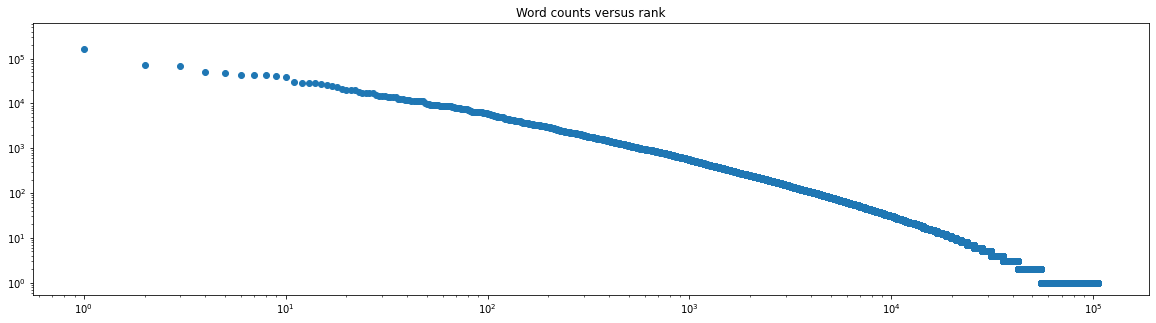

Vocabulary size: 105978
Part of the corpus by taking the "x" most frequent words ?
The 5000 most frequent words give 87.03232159162577 % of the corpus
The 10000 most frequent words give 92.19669633882879 % of the corpus


In [202]:
# We can for example use the function plt.scatter()
plt.figure(figsize=(20,5))
plt.title('Word counts versus rank')
plt.plot(freq_list,count_list, 'o')
plt.xscale('log')
plt.yscale('log')
plt.show()

# We would like to know how much of the data is represented by the 'k' most frequent words
print('Vocabulary size: %i' % len(vocab))
print('Part of the corpus by taking the "x" most frequent words ?')


num =np.sum(np.array(list(word_counts.values())[:5000]))
denom=np.sum(np.array(list(word_counts.values())))
print('The {} most frequent words give {} % of the corpus'.format(5000, num/denom*100))

num2 =np.sum(np.array(list(word_counts.values())[:10000]))
denom2=np.sum(np.array(list(word_counts.values())))
print('The {} most frequent words give {} % of the corpus'.format(10000, num2/denom2*100))

Result of the analysis: you should find that we can be satisfied with 10,000 or even 5,000 words - this is important, because it will determine the size of the objects we will manipulate. 

> We do indeed find that we are satisfied with 5000 words as they represent 87% of the corpus.

Throughout this plot we can see that we can only consider these 5000 as they represent a significant proportion of the corpus. This will help in reducing the time of computation without losing to much of precision.

In [203]:
vocab_5k, word_counts_5k = vocabulary(texts_reduced, 0, 5000)

In [204]:
print(vocab_5k['cinema'])

393


We could here compute the co-occurence matrix, and then reduce its dimension. Instead, we will use two of the most popular methods used to produce dense word representations (word embeddings). These methods are very different in practice, but are conceptually close, and resemble the procedure described earlier: reducing the dimension of co-occurences metrics.

## Getting a representation: commonly used algorithms

The idea here is to define a set of representations ${w_{i}}_{i=1}^{V}$, of predefined dimension $d$ (here, we will work with $d = 300$), for all the words $i$ of the vocabulary $V$ - then **train** these representations to match what we want. 

### Word2Vec


####  The skip-gram model

The basic skip-gram model tries to predict the context words $c$ surrounding a given center word $w$. Hence, it needs to estimate the probabilities of a pair of words $(i, j)$ to appear together in data:

$$P(j \mid i) = \frac{\exp(w_{i} c_{j})}{\sum_{j'\in V}\exp(w_{i} c_{j'})}$$


where $w_{i}$ is the lign vector (of the word) $i$ representing the center word and $c_{j}$ is the column vector (of one of the context words) $j$. The objective is to minimize the following quantity:


$$ -\sum_{i \in \mathcal{D}} \sum_{j \in \mathcal{N}_i} \sum_{k=1}^{|V|} \textbf{1}\{o_{i}=k\} \log \frac{\exp(w_{i} c_{k})}{\sum_{j=1}^{|V|} \exp(w_{i} c_{j})}$$


where $V$ is the vocabulary. Here, the first sum goes accross words $i$ the dataset $\mathcal{D}$; the second accross context words $j$ in the neighborhood $\mathcal{N}_i$ of word $i$; and the third sums probabilities the context word $j$ being the $k$-th word in the vocabulary for each $k \in V$.
The inputs $w_{i}$ are the representations of the center words, while $c_j$ are representations of the context words; both are made up of parameters, which are updated during training. Note that in this case, those representations are different, and we only keep the $w$ as final word representations to be used in NLP tasks - but it is possible to use the same parameters for $w$ and $c$, or to keep the mean of both representations at the end.  
The **desired output** of the model is an *one-hot* $o$ vector, which contains only one $1$ and $0$. For example, if `good` is the 47th word in the vocabulary, the output $o$ for an example when `good` is the word to predict will consist of $0$s everywhere except $1$ in the 47th position of the vector. `good` will be the word to predict when the input $w$ is a word in its context.
We therefore model this output with standard **softmax**, which will represent a probability distribution over $V$; and we add a bias term $b$. To obtain the vector of output probabilities, we need to vectorialize over all possible context words in $V$ - which means using the full matrix $C$ containing all vectors $c$.

$$ o = \textbf{softmax}(wC + b)$$

Here, we train the parameters contained in $W$ and $C$, two matrices representing the words in reduced dimension (300) using a maximum likelihood objective.

#### Skip-gram with negative sampling

The training of the skip-gram model implies to calculate a sum on the whole vocabulary, because of the *softmax*. As soon as the size of the vocabulary increases, it becomes impossible to compute. In order to make the calculations faster, we change the objective and use the method of *negative sampling* (or, very close to it, the *noise contrastive estimation*).


If here we note $\mathcal{N'}_i$ a set of words that are **not** in the context of the word $i$, the objective is:


$$ \sum_{i \in \mathcal{D}} \sum_{j \in \mathcal{N}_i} -\log\sigma(w_{i}c_{j}) + \sum_{i \in \mathcal{D}} \sum_{j \in \mathcal{N'}_i}\log\sigma(w_{i}c_{j})$$


where $\sigma$ is the sigmoid activation function $\frac{1}{1 + \exp(-x)}$.
In practice, we draw randomly these *negative* words that are not in the context, and we don't differentiate depending on the input word $i$: 

$$ \sum_{i \in \mathcal{D}} \sum_{j \in \mathcal{N}_i} -\log\sigma(w_{i}c_{j}) + \sum_{i \in \mathcal{D}} \sum_{j \in \mathcal{N'}}\log\sigma(w_{i}c_{j})$$

A common practice is to generate pairs from $\mathcal{N}'$ in proportion to the frequencies of the words in the training data (the so-called unigram distribution):


$$P(w) = \frac{\textbf{T}(w)^{0.75}}{\sum_{w'\in V} \textbf{T}(w')}$$


Although different, this new objective function is a sufficient approximation of the previous one, and is based on the same principle. Much research has been done on this objective: for example, [Levy and Golberg 2014](http://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization) shows that the objective calculates the PMI matrix shifted by a constant value. One can also see [Cotterell et al. 2017](https://aclanthology.coli.uni-saarland.de/papers/E17-2028/e17-2028) for an interpretation of the algorithm as a variant of PCA.

We will use the ```gensim``` library for its implementation of word2vec in python. We'll have to make a specific use of it, since we want to keep the same vocabulary as before: we'll first create the class, then get the vocabulary we generated above. 
To avoid having to put all the data in memory all at once, we define a generator, which will take all the input data and pre-process it, and return to the ```Word2Vec``` class sentence by sentence. 

In [205]:
from gensim.models import Word2Vec

# Creates the Word2Vec model with the relevant parameters
model = Word2Vec(vector_size=300,window=5,epochs=30)

# Get the vocabulary from the counts we created earlier
model.build_vocab_from_freq(word_counts_5k)

In [206]:
def preprocess_generator(large_corpus):
    for line in large_corpus:
        yield clean_and_tokenize(line)

In [207]:
preprocessed_corpus = [clean_and_tokenize(texts_reduced[i]) for i in range(len(texts_reduced))]
model.train(preprocessed_corpus, total_examples=len(texts_reduced), epochs=30, report_delay=1)

(8485321, 14018040)

In [208]:
W2VEmbeddings = model.wv.vectors

### Glove

The objective defined by Glove ([Pennington et al. (2014)](http://www.aclweb.org/anthology/D/D14/D14-1162.pdf)) is to learn from the vectors $w_{i}$ and $w_{k}$ so that their scalar product corresponds to the logarithm of their **Pointwise Mutual Information**: 


$$ w_{i}^\top w_{k} = (PMI(w_{i}, w_{k}))$$


In the article, this objective is carefully justified by a reasoning about the operations one wants to perform with these vectors and the properties they should have - in particular, symmetry between rows and columns (see the article for more details).  
The final goal obtained is the following, where $M$ is the co-occurrence matrix:


$$\sum_{i, j=1}^{|V|} f\left(M_{ij}\right)
  \left(w_i^\top w_j + b_i + b_j - \log M_{ij}\right)^2$$
  
 
Here, $f$ is a *scaling* function that reduces the importance of the most frequent co-occurrence counts: 


$$f(x) 
\begin{cases}
(x/x_{\max})^{\alpha} & \textrm{if } x < x_{\max} \\
1 & \textrm{otherwise}
\end{cases}$$


Usually, we choose $\alpha=0.75$ and $x_{\max} = 100$, although these parameters may need to be changed depending on the data.

The following code uses the gensim API to retrieve pre-trained representations (It is normal that the loading is long).

In [209]:
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")

We can extract the embedding matrix this way, and check its size:

In [210]:
loaded_glove_embeddings = loaded_glove_model.vectors
print(loaded_glove_embeddings.shape)

(400000, 300)


We can see that there are $400,000$ words represented, and that the embeddings are of size $300$. We define a function that returns, from the loaded model, the vocabulary and the embedding matrix according to the structures we used before. We add, here again, an unknown word "UNK" in case there are words in our data that are not part of the $400,000$ words represented here. 

In [211]:
def get_glove_voc_and_embeddings(glove_model):
    voc = {word : index for word, index in enumerate(glove_model.index_to_key)}
    voc['UNK'] = len(voc)
    embeddings = glove_model.vectors
    return voc, embeddings

In [212]:
loaded_glove_voc, loaded_glove_embeddings = get_glove_voc_and_embeddings(loaded_glove_model)

In order to compare the representations loaded here and the ones produced with word2vec, the same vocabulary should be used. For this purpose, I reuse the following code to create a $5000$ word vocabulary from the data, and I add at the end a function that returns the matrix of representations loaded with Glove for these $5000$ words only, in the right order. 

In [213]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.key_to_index.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc),glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

In [214]:
GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, vocab_5k)

This function takes as input the model loaded using the Gensim API, as well as a vocabulary we created ourselves, and returns the embedding matrix from the loaded model, for the words in our vocabulary and in the right order.
Note: unknown words are represented by a vector of zeros:

In [215]:
print(GloveEmbeddings.shape)
GloveEmbeddings[vocab_5k['UNK']]

(5001, 300)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

### Comparing vectors

These very large vectors can be used for a very basic semantic analysis: for example, by searching for the closest neighbors of a word. However, one must be careful with the distances used, related to certain metrics (Euclidean, Cosine) or possibly others related to belonging to sets (Matching, Jaccard). The normalization of vectors can also play a role. In any case, care must be taken not to over-interpret such results. 

In [216]:
def euclidean(u, v):
    return np.linalg.norm(u-v)

def length_norm(u):
    return u / np.sqrt(u.dot(u))

def cosine(u, v):
    return 1.0 - length_norm(u).dot(length_norm(v))

from sklearn.neighbors import NearestNeighbors

def print_neighbors(distance, voc, co_oc, mot, k=10):
    inv_voc = {id: w for w, id in voc.items()}
    neigh = NearestNeighbors(k, algorithm='brute', metric=distance)
    neigh.fit(co_oc) 
    dist, ind = neigh.kneighbors([co_oc[voc[mot]]])
    print("Plus proches voisins de %s selon la distance '%s': " % (mot, distance.__name__))
    print([[inv_voc[i] for i in s[1:]] for s in ind])
    
print_neighbors(euclidean, vocab_5k, W2VEmbeddings, 'good')
print_neighbors(cosine, vocab_5k, W2VEmbeddings, 'good')

print_neighbors(euclidean, vocab_5k, GloveEmbeddings, 'good')
print_neighbors(cosine, vocab_5k, GloveEmbeddings, 'good')

C:\Users\remij\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_neighbors=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
C:\Users\remij\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_neighbors=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
C:\Users\remij\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_neighbors=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
C:\Users\remij\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_neighbors=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positiona

Plus proches voisins de good selon la distance 'euclidean': 
[['killed', 'normal', 'deserve', 'information', 'mistake', 'thomas', 'mess', 'escape', 'packed']]
Plus proches voisins de good selon la distance 'cosine': 
[['killed', 'normal', 'bad', 'waste', 'funny', 'deserve', 'home', 'information', 'sure']]
Plus proches voisins de good selon la distance 'euclidean': 
[['better', 'well', 'always', 'really', 'sure', 'way', 'but', 'excellent', 'certainly']]
Plus proches voisins de good selon la distance 'cosine': 
[['better', 'really', 'always', 'you', 'well', 'excellent', 'very', 'things', 'think']]


### Visualisation in two dimensions

We will now use **principal component analysis** (PCA) to visualize our data in 2 dimensions.  This is equivalent to applying SVD to the covariance matrix of the data, so that the principal directions are independent of each other and maximize the variance of the data.
We use the class ```PCA``` from the ```scikit-learn``` package: 

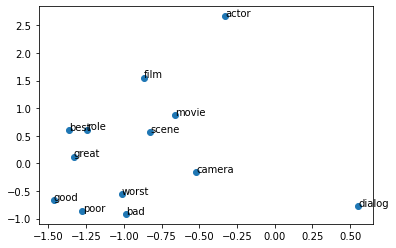

In [217]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)
Emb = pca.fit_transform(GloveEmbeddings)

# i kicked oscar and award of words because it wasn't in my version of vocab_5k in this cell and the following one. 
# it may be due to my function vocabulary but i don't see the mistake in it, maybe due to the limitation of the vocabulary

words = ['bad', 'good', 'best', 'worst', 'poor', 'great',
         'dialog', 'role', 'actor', 'camera', 'scene',
         'film', 'movie']
ind_words = [vocab_5k[w] for w in words]
x_words = [Emb[ind,0] for ind in ind_words]
y_words = [Emb[ind,1] for ind in ind_words]

fig, ax = plt.subplots()
ax.scatter(x_words, y_words)

for i, w in enumerate(words):
    ax.annotate(w, (x_words[i], y_words[i]), (x_words[i] + 0.001, y_words[i] + 0.001))


In two dimensions, the positive comments and negative comments form two clusters. The words "best", "good" and "good" are together such as "worst", "poor" and "bad". However, these two clusters are very close to each other and no real frontier seems to seperate the two groups.

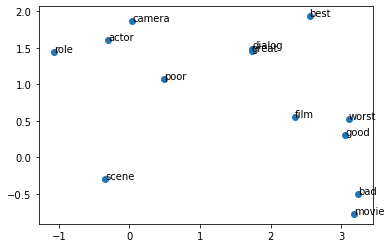

In [218]:
pca = PCA(n_components=2, whiten=True)
Emb = pca.fit_transform(W2VEmbeddings)

# i kicked oscar and award of words because it wasn't in my version of vocab_5k

words = ['bad', 'good', 'best', 'worst', 'poor', 'great',
         'dialog', 'role', 'actor', 'camera', 'scene',
         'film', 'movie']
ind_words = [vocab_5k[w] for w in words]
x_words = [Emb[ind,0] for ind in ind_words]
y_words = [Emb[ind,1] for ind in ind_words]

fig, ax = plt.subplots()
ax.scatter(x_words, y_words)

for i, w in enumerate(words):
    ax.annotate(w, (x_words[i], y_words[i]), (x_words[i] + 0.001, y_words[i] + 0.001))

Try to obtain visualisation for more words/words that may be interesting given the data !

## Application to sentiment analysis

We will now use these representations for sentiment analysis. 
The basic model, as before, will be constructed in two steps:
- A function to obtain vector representations of criticism, from text, vocabulary, and vector representations of words. Such a function (to be completed below) will associate to each word of a review its embeddings, and create the representation for the whole sentence by summing these embeddings.
- A classifier will take these representations as input and make a prediction. To achieve this, we can first use logistic regression ```LogisticRegression``` from ```scikit-learn```  

In [219]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.sum):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences   
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise, 
        like `np.mean`, `np.sum`, or `np.prod`. 
    Returns
    -------
    np.array, dimension `(len(texts), embeddings.shape[1])`            
    """
    shape = (len(texts), embeddings.shape[1])
    representations = np.zeros(shape)
    
    for i in range(len(texts)):
        sentence = texts[i]
        words = clean_and_tokenize(sentence)

        embeddings_w = []
        for word in words:
            if word in vocabulary:
                embeddings_w.append(vocabulary[word]) 
            else:
                embeddings_w.append(vocabulary['UNK'])
       
        representation = np_func(embeddings_w)
        representations[i] = representation
    
    return representations

In [220]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Exemple avec les embeddings obtenus via Glove
rep = sentence_representations(texts_reduced, vocab_5k, GloveEmbeddings)
clf = LogisticRegression().fit(rep[::2], y_reduced[::2])
print(clf.score(rep[1::2], y_reduced[1::2]))

scores = cross_val_score(clf, rep, y_reduced, cv=5)
print('Score de classification: %s (std %s)' % (np.mean(scores), np.std(scores)))

0.5
Score de classification: 0.5 (std 0.0)


Why can we expect that the results obtained with embeddings extracted from representations pre-trained with Gl0ve are much better than word2vec ? What would be the way to compare Gl0ve with word2vec in a 'fair' way ? 

 > The two models work in a different way : Gl0ve is a count baised model and wor2vec is a predictive model. So the fact that we have a large corpus here makes the Gl0ve model efficient. Moreover it does not rely on local context informations of words but (like word2vec) rather uses the word co occurences to obtain word vectors).

Try to play with word2vec parameters to improve results !

> In order to better the results of word2vec we can increase the window size of word considered by the algorithm, the training set and the dimension of the vectors. Nevertheless this solution is not optimal because when we increase the training set or the size of the window we also increase the time of computation. So, as always in the models choice we must find a balance between accuracy and computation time. 